# PROJETO: Modelagem de dados da SSP-SP / Modeling of SSP-SP data

## João Leopoldo e Silva - fev/2020

#### dataset: https://www.kaggle.com/inquisitivecrow/crime-data-in-brazil
## 2007

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
import joblib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import joblib

In [3]:
pd.options.display.max_columns = 200

In [ ]:
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix

In [4]:
data_2007_1 = pd.read_csv('crime-data-in-brazil/BO_2007_1.csv', low_memory=False)
data_2007_2 = pd.read_csv('crime-data-in-brazil/BO_2007_2.csv', low_memory=False)
data_2007 = pd.concat([data_2007_1, data_2007_2], ignore_index=True)

In [5]:
data_2007.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438704 entries, 0 to 1438703
Data columns (total 30 columns):
NUM_BO                    1438704 non-null int64
ANO_BO                    1438704 non-null int64
ID_DELEGACIA              1438704 non-null int64
NOME_DEPARTAMENTO         1438704 non-null object
NOME_SECCIONAL            1438704 non-null object
DELEGACIA                 1438704 non-null object
NOME_DEPARTAMENTO_CIRC    1438704 non-null object
NOME_SECCIONAL_CIRC       1438704 non-null object
NOME_DELEGACIA_CIRC       1438704 non-null object
ANO                       1438704 non-null int64
MES                       1438704 non-null int64
DATA_OCORRENCIA_BO        1431882 non-null object
HORA_OCORRENCIA_BO        1256280 non-null object
FLAG_STATUS               1438704 non-null object
RUBRICA                   1438704 non-null object
DESDOBRAMENTO             42095 non-null object
CONDUTA                   1018792 non-null object
LATITUDE                  50713 non-null obj

In [5]:
conduta = data_2007.CONDUTA.value_counts().nlargest(7).index
joblib.dump(conduta, 'conduta7')

['conduta7']

In [6]:
profissao = data_2007_1.DESCR_PROFISSAO.value_counts().nlargest(15).index
joblib.dump(profissao, 'profissao7')

['profissao7']

In [7]:
instrucao = data_2007_1.DESCR_GRAU_INSTRUCAO.value_counts().nlargest(15).index
joblib.dump(instrucao, 'instrucao7')

['instrucao7']

In [8]:
def hora(x):
    try:
        if int(x[:2]) < 6:
            return 'Madrugada'
        elif int(x[:2]) < 12:
            return 'Manhã'
        elif int(x[:2]) < 18:
            return 'Tarde'
        else:
            return 'Noite'
    except:
        return 'Indeterminado'

In [9]:
rub_dict = joblib.load('rub_dict')

In [10]:
data_2007['hora'] = data_2007.HORA_OCORRENCIA_BO.apply(hora)

In [11]:
data_2007.sample()

,NUM_BO,ANO_BO,ID_DELEGACIA,NOME_DEPARTAMENTO,NOME_SECCIONAL,DELEGACIA,NOME_DEPARTAMENTO_CIRC,NOME_SECCIONAL_CIRC,NOME_DELEGACIA_CIRC,ANO,MES,DATA_OCORRENCIA_BO,HORA_OCORRENCIA_BO,FLAG_STATUS,RUBRICA,DESDOBRAMENTO,CONDUTA,LATITUDE,LONGITUDE,CIDADE,LOGRADOURO,NUMERO_LOGRADOURO,FLAG_STATUS.1,DESCR_TIPO_PESSOA,CONT_PESSOA,SEXO_PESSOA,IDADE_PESSOA,COR,DESCR_PROFISSAO,DESCR_GRAU_INSTRUCAO,hora
1184308,11329,2007,10101,DECAP,DEL.SEC.1º CENTRO,01º D.P. SE,DECAP,DEL.SEC.1º CENTRO,01º D.P. SE,2007,9,22/09/2007,20:00,C,Furto (art. 155),NaN,TRANSEUNTE,NaN,NaN,S.PAULO,PC DA SE,1,C,Vítima,1,F,19,Branca,VENDEDOR(A),2 Grau completo,Noite


In [12]:
target = data_2007.RUBRICA.apply(lambda x: rub_dict[x])

In [13]:
data_2007f = data_2007[['NOME_DEPARTAMENTO_CIRC','NOME_SECCIONAL_CIRC',
                       'IDADE_PESSOA','FLAG_STATUS', 'DESCR_TIPO_PESSOA',
                       'SEXO_PESSOA','COR', 'hora','CONDUTA','DESCR_PROFISSAO','DESCR_GRAU_INSTRUCAO']]

In [14]:
data_2007f = pd.get_dummies(data=data_2007f, columns=['NOME_DEPARTAMENTO_CIRC','NOME_SECCIONAL_CIRC',
                                                       'FLAG_STATUS', 'DESCR_TIPO_PESSOA', 
                                                       'SEXO_PESSOA','COR', 'hora'])

In [15]:
data_2007f.loc[data_2007f['IDADE_PESSOA'] == '22 ANOS                 '] = '22'
data_2007f.loc[data_2007f['IDADE_PESSOA'] == ' 17/18 ANOS                         '] = '17'
data_2007f.loc[data_2007f['IDADE_PESSOA'] == ' CERCA DE 30/35 ANOS                 '] = '30'
data_2007f.loc[data_2007f['IDADE_PESSOA'] == ' 57 ANOS                    '] = '57'
data_2007f.loc[data_2007f['IDADE_PESSOA'] == ' 23 ANOS                         '] = '23'
data_2007f.loc[data_2007f['IDADE_PESSOA'] == 'M'] = np.nan
data_2007f.loc[data_2007f['IDADE_PESSOA'] == 'F'] = np.nan
data_2007f.loc[data_2007f['IDADE_PESSOA'] == ' 18 ANOS                         '] = '18'
data_2007f.loc[data_2007f['IDADE_PESSOA'] == 'TER 18 A 20 ANOS                  '] = '18'
data_2007f.loc[data_2007f['IDADE_PESSOA'] == ' 21 ANOS)                      '] = '21'
data_2007f.loc[data_2007f['IDADE_PESSOA'] == ' 27 ANOS                         '] = '27'

In [16]:
data_2007f['IDADE_PESSOA'] = pd.to_numeric(data_2007f['IDADE_PESSOA'])

In [17]:
conduta = joblib.load('conduta7')
conduta_2007 = pd.get_dummies(data_2007f.CONDUTA.where(data_2007f.CONDUTA.isin(conduta), other='Other'))

profissao = joblib.load('profissao7')
profissao_2007 = pd.get_dummies(data_2007f.DESCR_PROFISSAO.where(data_2007f.DESCR_PROFISSAO.isin(profissao), other='Other'))

instrucao = joblib.load('instrucao7')
instucao_2007 = pd.get_dummies(data_2007f.DESCR_GRAU_INSTRUCAO.where(data_2007f.DESCR_GRAU_INSTRUCAO.isin(instrucao), other='Other'))

In [18]:
data_2007f = pd.concat([data_2007f, conduta_2007, profissao_2007, instucao_2007], axis=1).drop(columns=['CONDUTA','DESCR_PROFISSAO','DESCR_GRAU_INSTRUCAO'])

In [19]:
# data_2007f.columns
# data_2007f.loc[data_2007f['DESCR_TIPO_PESSOA_C'] == '0']
# data_2007f.loc[data_2007f['SEXO_PESSOA_1'] == '0']
data_2007f = data_2007f.drop(columns=['DESCR_TIPO_PESSOA_C', 'SEXO_PESSOA_1'])

In [20]:
data_2007f.shape

(1438704, 85)

In [21]:
data_2007f = data_2007f.fillna(0)

In [22]:
data_2007f = data_2007f.apply(pd.to_numeric, downcast='integer')

#### modelagem

In [23]:
import lightgbm
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ROCAUC

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [25]:
X = data_2007f
X.columns = range(len(X.columns))

In [26]:
# target = data_2007.RUBRICA.apply(lambda x: rub_dict[x])

y = target.values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [28]:
# model = lightgbm.LGBMClassifier(n_estimators=30, max_depth=2, colsample_bytree=0.7)

model = lightgbm.LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### rodando modelo e verificando performance

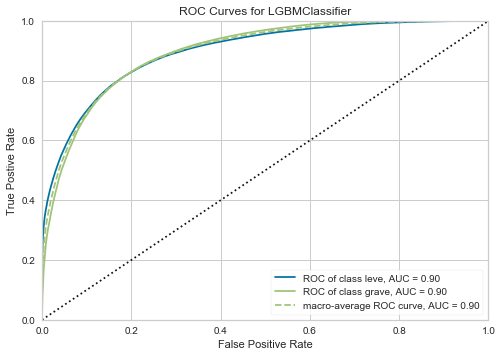

In [29]:
model_roauc = ROCAUC(model, classes=["leve", "grave"], micro=False)

model_roauc.fit(X_train, y_train)
model_roauc.score(X_test, y_test)
model_roauc.show();

In [30]:
y_score = model.predict_proba(X_test)[:,1]
pd.DataFrame(y_score)

,0
0,0.987309
1,0.987829
2,0.873798
3,0.690909
4,0.537746
...,...
287736,0.995755
287737,0.408819
287738,0.619389
287739,0.978090


In [31]:
roc_auc_score(y_test, y_score)

0.897833133809967

In [32]:
model_roauc.predict_proba(X_test)

array([[0.01269074, 0.98730926],
       [0.01217145, 0.98782855],
       [0.12620158, 0.87379842],
       ...,
       [0.38061085, 0.61938915],
       [0.02191022, 0.97808978],
       [0.65164097, 0.34835903]])

In [33]:
y_train.mean()

0.7105258813706435

In [34]:
y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [35]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,52308,30988
1,13923,190522


In [36]:
# acurácia = o que eu acertei / todos os casos
(52308+190522)/287741

0.843918662964263

#### matriz de confusão

In [37]:
from yellowbrick.classifier import ConfusionMatrix

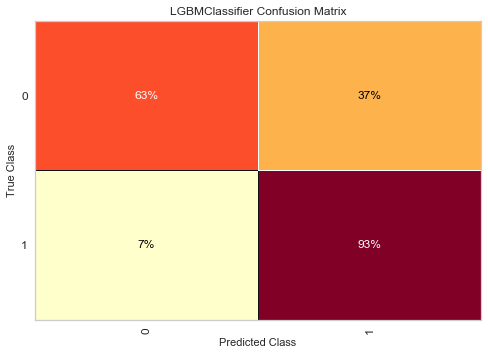

In [38]:
cm = ConfusionMatrix(model, percent=True)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)

cm.show()

In [39]:
from sklearn.metrics import recall_score, accuracy_score

In [40]:
recall_score(y_test, y_pred)

# capturei 93% dos casos graves

0.9318985546234929

In [41]:
accuracy_score(y_test, y_pred)

0.843918662964263

#### salvando modelo

In [42]:
joblib.dump(model, 'modelo_bo_2007.pkl')

['modelo_bo_2007.pkl']